## Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import linregress

from datetime import datetime
import random
import os
import seaborn as sns
import importlib

from PIL import Image
from sklearn.cluster import KMeans

In [2]:
np.set_printoptions(linewidth=160)
np.get_printoptions()['linewidth']

160

In [3]:
from skimage.segmentation import slic
from skimage.color import rgb2lab, lab2rgb
from skimage.util import img_as_ubyte
from skimage.measure import regionprops

from scipy.ndimage import rotate

from skimage.filters import gaussian
from skimage.morphology import dilation, disk

from skimage.filters.rank import gradient

## Start

In [4]:
import src.ArT_functions; import src.comic_book; import src.general_functions
importlib.reload(src.ArT_functions); importlib.reload(src.comic_book); importlib.reload(src.general_functions);
from src.ArT_functions import *; from src.comic_book import *; from src.general_functions import *

In [5]:
input_image_path = 'input/1705_JesseMetz1439.jpg'
output_image_path = 'output/output_image.jpg'
input_image = extract_square(input_image_path, target_size=1000)

In [6]:
input_image = extract_square(input_image_path, target_size=300)
img_array = np.array(input_image)
rows, cols, channels = img_array.shape
rows, cols, channels

(300, 300, 3)

## Move boxes

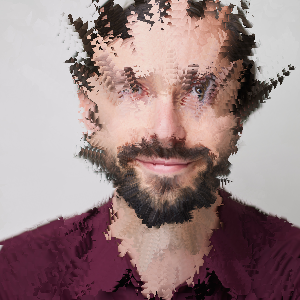

In [7]:
# altered_image = alter_image_init(input_image, num_fragments=100, offset_ratio=.1)
# altered_image = alter_image_init_circles(input_image, num_fragments=10, offset_ratio=1)
# altered_image = alter_image_boxes_away_from_center(input_image, num_rectangles=1000)
# altered_image = alter_image_boxes(input_image, num_rectangles=10000, magnitude=.1)
# altered_image = alter_image_boxes_rotation_basic(input_image, num_rectangles=1000, magnitude=1, rotation_range=10)
# altered_image = alter_image_boxes_rotation(input_image, shape_size=5, num_rectangles=100, magnitude_shift=1, rotation_mean=10, rotation_var=1)
altered_image = alter_image_shapes_with_border_expansion(
    input_image,
    shape_type="pentagon",
    shape_size=1,
    num_shapes=1000,
    magnitude_shift=1,
    rotation_mean=1,
    rotation_var=0,
)

# save_image_with_unique_name(altered_image, output_image_path)
altered_image

In [8]:
# np.random.seed(46)
# altered_image = alter_image_shapes_rotation(input_image, fragments_size_fraction=10, offset_ratio=1, shape_type="triangle", shape_rotation=False, fragment_rotation=False)
# save_image_with_unique_name(altered_image, output_image_path)
# altered_image

## Segments

In [9]:
stop

NameError: name 'stop' is not defined

In [ ]:
def segment_image_with_background(img, number_of_regions, background_color=(255, 255, 255), region_size_factor=5):
    img_array = np.array(img)

    # Convert image to LAB color space for better segmentation
    img_lab = rgb2lab(img_array)

    # Calculate the maximum size per region based on the image width
    max_region_size = img.width // region_size_factor

    # Perform SLIC segmentation
    segments = slic(
        img_lab,
        n_segments=number_of_regions,
        compactness=10, 
        max_size_factor=max_region_size,
        start_label=1,
    )

    # Identify the largest region as the background
    regions = regionprops(segments)
    largest_region = max(regions, key=lambda r: r.area)
    
    # Create a new image and fill with random colors and background color
    segmented_img = np.zeros_like(img_array)
    for region in regions:
        coords = region.coords
        if region.label == largest_region.label:
            segmented_img[coords[:, 0], coords[:, 1]] = background_color  # Set background color
        else:
            random_color = np.random.randint(0, 256, size=3)  # Assign random colors to other regions
            segmented_img[coords[:, 0], coords[:, 1]] = random_color

    # Convert back to PIL image
    segmented_img_pil = Image.fromarray(img_as_ubyte(segmented_img))
    return segmented_img_pil

In [ ]:
# background_img = segment_image_with_background(input_image, number_of_regions=100, background_color=(255, 255, 255))
# save_image_with_unique_name(background_img, output_image_path)
# background_img

In [ ]:
def segment_image_with_background_irregular(
    img,
    number_of_regions,
    region_size_factor=5,
    compactness=5,
    blur_sigma=2,
):
    img_array = np.array(img)

    # Convert image to LAB color space for better segmentation
    img_lab = rgb2lab(img_array)

    # Apply Gaussian blur to smooth the image for more natural segmentation
    img_lab_blurred = gaussian(img_lab, sigma=blur_sigma)

    # Calculate the maximum size per region based on the image width
    max_region_size = img.width // region_size_factor

    # Perform SLIC segmentation with adjusted parameters
    segments = slic(
        img_lab_blurred,
        n_segments=number_of_regions,
        compactness=compactness,  # Lower compactness for more irregular shapes
        start_label=1,
    )

    regions = regionprops(segments)
    
    # Create a new image and fill with random colors
    segmented_img = np.zeros_like(img_array)
    for region in regions:
        coords = region.coords
        random_color = np.random.randint(0, 256, size=3)  # Assign random colors the other regions
        segmented_img[coords[:, 0], coords[:, 1]] = random_color

    # Post-process: Apply dilation for more irregular region borders
    for c in range(3):  # Iterate over color channels
        segmented_img[..., c] = dilation(segmented_img[..., c], disk(1))  # Use a disk kernel for dilation

    # Convert back to PIL image
    segmented_img_pil = Image.fromarray(segmented_img.astype("uint8"))
    return segmented_img_pil

In [ ]:
# segmented_img = segment_image_with_background_irregular(
#     img=input_image,
#     number_of_regions=50,
#     region_size_factor=4,
#     compactness=1,
#     blur_sigma=5,
# )

# save_image_with_unique_name(segmented_img, output_image_path)
# segmented_img

In [ ]:
def segment_image_with_variance_based_regions(
    img,
    base_number_of_regions,
    region_size_factor=5,
    compactness=5,
    blur_sigma=2,
    gradient_disk_size=5,
    variance_threshold=0.2,
):
    img_array = np.array(img)

    # Convert image to LAB color space for better segmentation
    img_lab = rgb2lab(img_array)

    # Apply Gaussian blur to smooth the image for more natural segmentation
    img_lab_blurred = gaussian(img_lab, sigma=blur_sigma)

    # Calculate local gradient magnitude to estimate variance in pixel colors
    intensity_gradient = gradient(
        (img_lab_blurred[..., 0] * 255).astype(np.uint8),  # Use L-channel for intensity
        disk(gradient_disk_size),
    )

    # Normalize gradient map to [0, 1] for scaling number of regions
    normalized_gradient = intensity_gradient / intensity_gradient.max()

    # Map gradient values to local region size adjustment
    gradient_scaled_regions = (base_number_of_regions * (1 + (1 - normalized_gradient) * variance_threshold)).astype(int)

    # Perform SLIC segmentation with dynamic region adjustments
    segments = slic(
        img_lab_blurred,
        n_segments=int(gradient_scaled_regions.mean()),  # Average adjusted regions
        compactness=compactness,  # Lower compactness for more irregular shapes
        start_label=1,
    )

    # Get region properties
    regions = regionprops(segments)
    
    # Create a new image and fill with random colors
    segmented_img = np.zeros_like(img_array)
    for region in regions:
        coords = region.coords
        random_color = np.random.randint(0, 256, size=3)  # Assign random colors to regions
        segmented_img[coords[:, 0], coords[:, 1]] = random_color

    # Post-process: Apply dilation for more irregular region borders
    for c in range(3):  # Iterate over color channels
        segmented_img[..., c] = dilation(segmented_img[..., c], disk(1))  # Use a disk kernel for dilation

    # Convert back to PIL image
    segmented_img_pil = Image.fromarray(segmented_img.astype("uint8"))
    return segmented_img_pil

In [ ]:
startTime = datetime.now()
# np.random.seed(46)
segmented_img = segment_image_with_variance_based_regions(
    img=input_image,
    base_number_of_regions=200,
    region_size_factor=1, # not in use
    compactness=0.01,
    blur_sigma=5,
    gradient_disk_size=100,
    variance_threshold=0.2,
)

save_image_with_unique_name(segmented_img, output_image_path)
print (datetime.now() - startTime)
segmented_img

##### Gradient-Based Variance Map:
A local gradient filter is applied to estimate the variation in pixel intensities. Regions with high gradients indicate areas of high variation.

##### Dynamic Region Scaling:
The gradient_scaled_regions is calculated by scaling the base number of regions dynamically based on the gradient values. This ensures larger regions in low-variation areas and smaller regions in high-variation areas.

##### Variance Threshold:
The variance_threshold parameter controls how strongly the number of regions is adjusted based on the variance.

##### Gradient Disk Size:
The gradient_disk_size parameter determines the size of the neighborhood used to calculate local variance. Larger values smooth out the variance map more.

In [ ]:
def segment_image_with_spatial_constraints(img, number_of_regions, region_size_factor=5, color_style="colors"):
    img_array = np.array(img)

    # Convert image to LAB color space for better color segmentation
    img_lab = rgb2lab(img_array)

    # Calculate the maximum size per region based on the image width
    max_region_size = img.width // region_size_factor
    
    # Perform SLIC segmentation
    segments = slic(
        img_lab,
        n_segments=number_of_regions,
        compactness=10,  # Balances color similarity and spatial proximity; adjust if needed
        max_size_factor=max_region_size,
        start_label=1,
    )

    # Replace each segment with a random color
    if color_style == "colors":  # Random colors
        segmented_img = np.zeros_like(img_array)
        for region in regionprops(segments):
            coords = region.coords
            random_color = np.random.randint(0, 256, size=3)  # Generate a random RGB color
            segmented_img[coords[:, 0], coords[:, 1]] = random_color
    else:  # 
        segmented_img = np.zeros_like(img_array)
        for region in regionprops(segments):
            # Get pixel indices for each region
            coords = region.coords
            # Average the color of each region
            average_color = np.mean(img_array[coords[:, 0], coords[:, 1]], axis=0)
            # Fill the region with the average color
            segmented_img[coords[:, 0], coords[:, 1]] = average_color

    # Convert back to PIL image
    segmented_img_pil = Image.fromarray(img_as_ubyte(segmented_img))
    return segmented_img_pil

In [ ]:
# segmented_img = segment_image_with_spatial_constraints(input_image, number_of_regions=100, color_style="colors")

# # save_image_with_unique_name(segmented_img, output_image_path)
# segmented_img